Using TensorFlow backend.


loaded model from model-32.h5


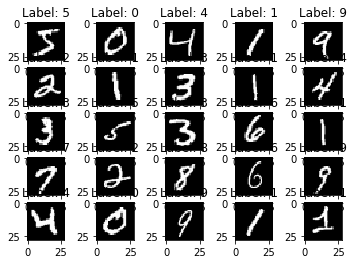

[5]


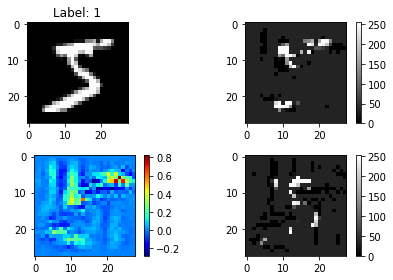

[0]


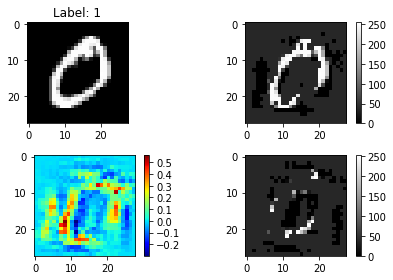

[4]


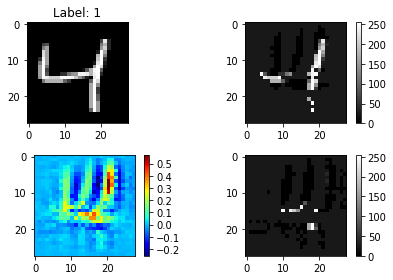

[1]


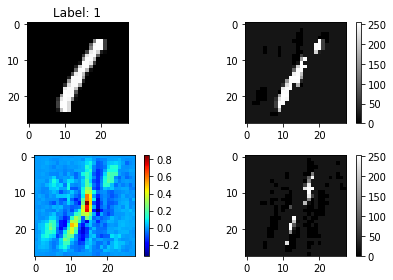

[9]


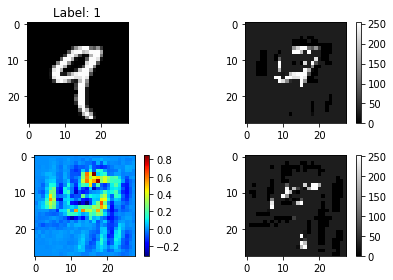

[2]


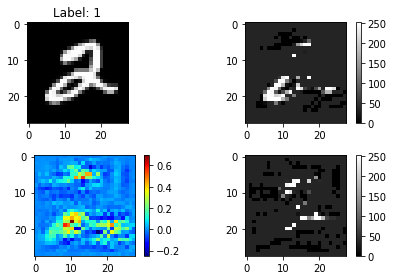

[1]


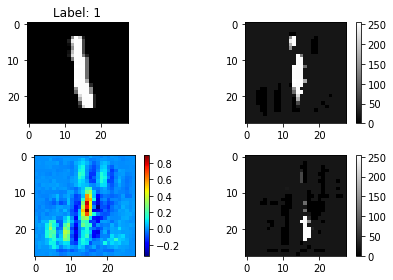

[3]


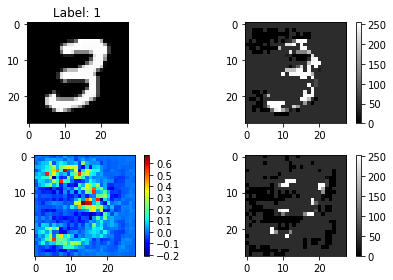

[1]


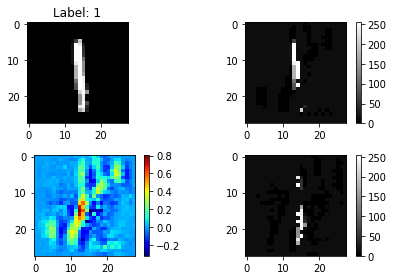

[4]


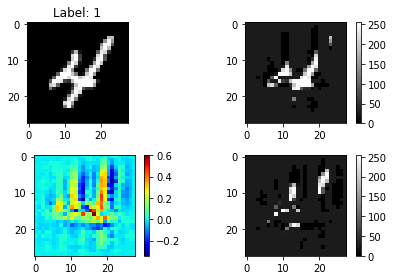

[3]


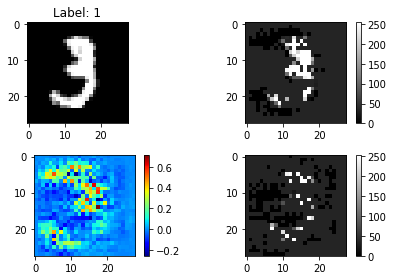

[5]


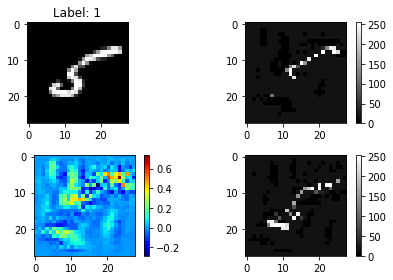

[3]


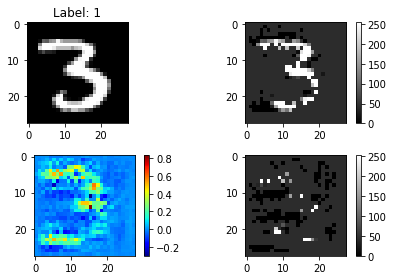

[6]


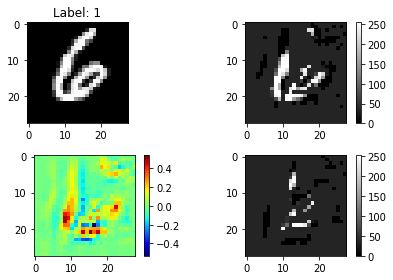

[1]


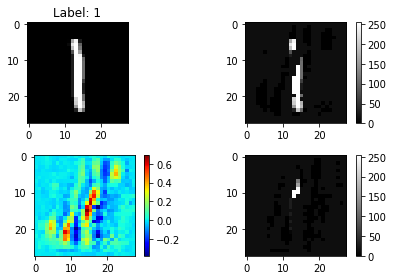

[7]


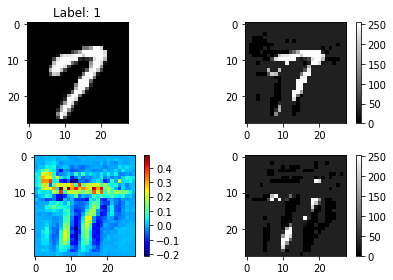

[2]


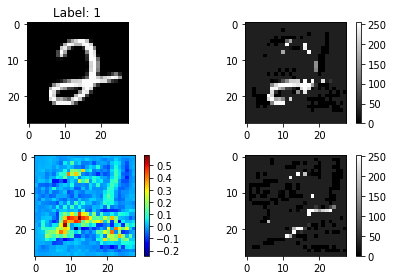

[8]


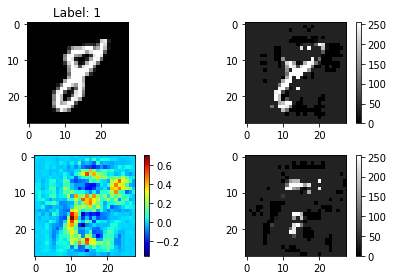

[6]


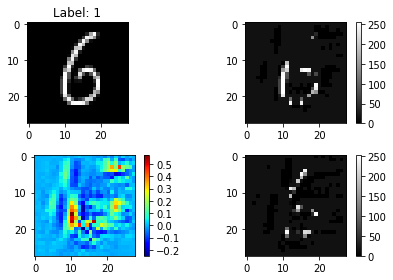

[9]


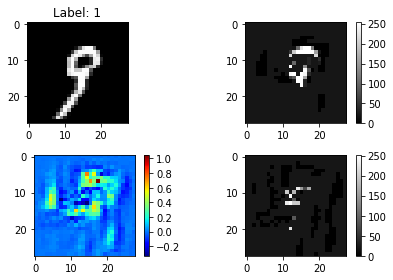

[4]


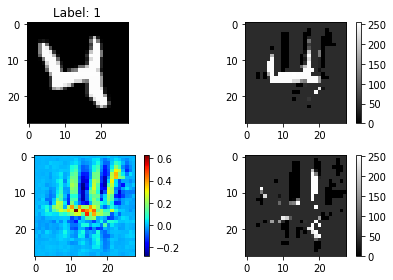

[0]


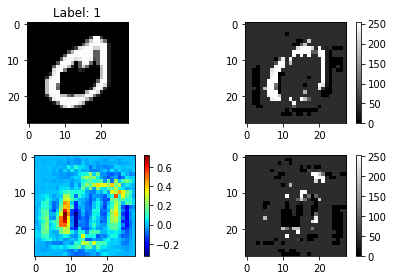

[9]


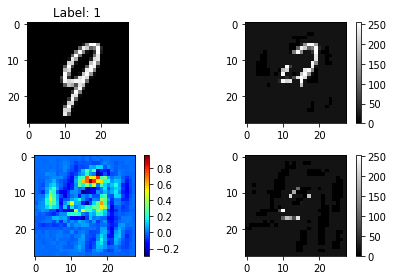

[1]


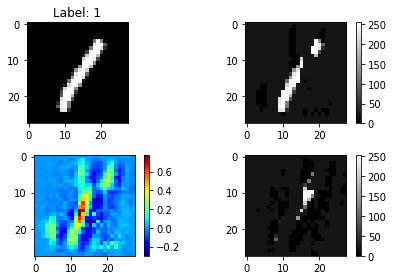

[3]


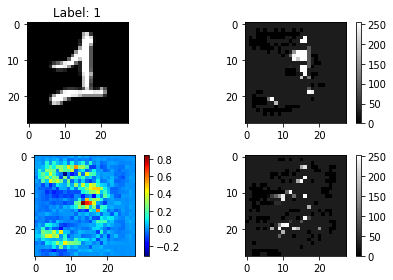

In [1]:
# Build saliency map for CNN model
import os
import struct
import argparse
from keras.models import load_model
from termcolor import colored, cprint
import keras.backend as K
from keras.utils import *
import numpy as np
import matplotlib.pyplot as plt

epoch = 32
NUM_STEPS = 10000
LR_RATE = 2e-2
num = 10000
ratio = 0.1

 ######## Build folder for loading and saving analysis images. ######## 
model_name = 'MNIST_model_fixed_20180118'
base_dir = 'C:/Users/User/Raw data/CNN_test'

img_dir = os.path.join(base_dir, 'image')
if not os.path.exists(img_dir):
    os.makedirs(img_dir)
img_name_dir = os.path.join(img_dir, model_name)
if not os.path.exists(img_name_dir):
    os.makedirs(img_name_dir)
see_dir = os.path.join(img_name_dir, 'saliency_map')
if not os.path.exists(see_dir):
    os.makedirs(see_dir)

mdl_dir = os.path.join(base_dir, 'model')
if not os.path.exists(mdl_dir):
    os.makedirs(mdl_dir)
model_dir = os.path.join(mdl_dir, model_name)
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

 ######## Define tool function ######## 
def readfile():
    with open(base_dir + '/datasets/MNIST/train-images.idx3-ubyte','rb') as f1:
        buf1 = f1.read()
    with open(base_dir + '/datasets/MNIST/train-labels.idx1-ubyte','rb') as f2:
        buf2 = f2.read()
    return buf1, buf2

def get_image(buf1, num):
    image_index = 0
    image_index += struct.calcsize('>IIII')
    im = []
    for i in range(num):
        temp = struct.unpack_from('>784B', buf1, image_index) # '>784B'的意思就是用大端法读取784个unsigned byte
        im.append(np.reshape(temp,(28,28)))
        image_index += struct.calcsize('>784B')  # 每次增加784B
    return im


def get_label(buf2, num): # 得到标签数据
    label_index = 0
    label_index += struct.calcsize('>II')
    return struct.unpack_from('>{}B'.format(num), buf2, label_index)

def normalized(a, axis=-1, order=2):
    l2 = np.atleast_1d(np.linalg.norm(a, order, axis))
    l2[l2==0] = 1
    return a / np.expand_dims(l2, axis)

 ######## Build and run saliency map model ######## 
def saliency_map():
    rows = 5
    cols = 5
    img_ids = rows * cols
    model_file_name = 'model-{}.h5'.format(epoch)
    model_path = os.path.join(model_dir, model_file_name)
    emotion_model = load_model(model_path)
    print(colored('loaded model from {}'.format(model_file_name), 'yellow', attrs=['bold']))
    
    image_data, label_data = readfile()
    model_img = get_image(image_data, num)
    model_label = get_label(label_data, num)
    
    for i in range(img_ids):
        plt.subplot(rows, cols, i + 1)
        title = u"Label: "+ str(model_label[i])
        plt.title(title)
        plt.imshow(model_img[i], cmap='gray')
    plt.show()
    
    input_img = emotion_model.input
    output_img = emotion_model.output
    fn = []
    for label_id in range(output_img.shape[-1]):
        target = emotion_model.output[:, label_id]
        grads = K.gradients(target, input_img)[0]
        fn.append(K.function([input_img, K.learning_phase()], [grads]))
    
    for idx in range(img_ids):
        private_pixels = np.reshape(model_img[idx], (1, 28, 28, 1))
        val_predict = emotion_model.predict(private_pixels)
        pred = val_predict.argmax(axis=-1)
        print(pred)
        rand_nmist = np.random.random((1, 28, 28, 1))
        grad_out = fn[pred[0]]([rand_nmist, 0])
        for i in range(NUM_STEPS):
            grads_value = fn[pred[0]]([grad_out[0], 0])
            grad_out[0] += grads_value[0] * LR_RATE
                    
        grad_out = np.reshape(grad_out, (28, 28))
        
        grad_max = np.amax(grad_out, axis=None)
        grad_min = np.amin(grad_out, axis=None)
        
        see_pos = np.array(model_img[idx])
        see_neg = np.array(model_img[idx])
        see_pos[np.where(grad_out < (grad_max * ratio))] = np.mean(model_img[idx], axis=None)
        see_neg[np.where(grad_out > (grad_min * ratio))] = np.mean(model_img[idx], axis=None)
        
        plt.figure()
        plt.subplot(2, 2, 1)
        plt.title(title)
        plt.imshow(model_img[idx], cmap='gray')
        
        plt.subplot(2, 2, 3)
        plt.imshow(grad_out, cmap=plt.cm.jet)
        plt.colorbar()
        
        plt.subplot(2, 2, 2)
        plt.imshow(see_pos, cmap='gray')
        plt.colorbar()
        
        plt.subplot(2, 2, 4)
        plt.imshow(see_neg, cmap='gray')
        plt.colorbar()
        
        plt.tight_layout()
        plt.draw()
        fig = plt.gcf()
        test_dir = os.path.join(see_dir, '{}_epoch{}'.format(model_name, epoch))
        if not os.path.exists(test_dir):
            os.makedirs(test_dir)
        fig.savefig(os.path.join(test_dir, 'image{}-label{}-predict{}.png'.format(idx, model_label[idx], pred)), dpi=100)
        
        plt.show()
    
saliency_map()